In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy import integrate


sample = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
m = len(sample)
n = sum(sample)
alpha = 0.05

# --------Пункт А--------

# Критерий Колмогорова

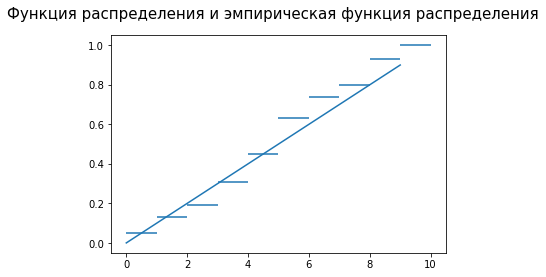

In [3]:
F = [sample[0]/n]
for i in range(1, m):
    F.append(F[-1] + sample[i]/n)


    
x_uni = [i for i in range(m)]
y_uni = [(x_uni[i])/10 for i in range(m)]    #R(a, b) = R(0, 10)

fig, ax = plt.subplots()
fig.suptitle('Функция распределения и эмпирическая функция распределения', size=15)

for i in range(1, m+1):
    ax.hlines(F[i-1], i-1, i)

plt.plot(x_uni, y_uni)
plt.show()

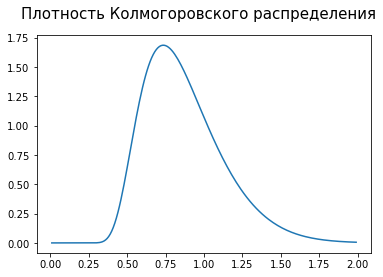

In [4]:
def K_density(x):
    return 8*sum([pow(-1, k+1)*pow(math.e, (-2*k**2*x**2))*k**2*x for k in range(1, 1000)])

x_kalm, y_kalm = [], []
for i in range(1, 200):
    x_kalm.append(i/100) 
    y_kalm.append(K_density(x_kalm[-1])) 

fig, ax = plt.subplots()
fig.suptitle('Плотность Колмогоровского распределения', size=15)
plt.plot(x_kalm, y_kalm)
plt.show()


In [5]:
delta_kalm = math.sqrt(n)*max([abs(F[i]-y_uni[i]) for i in range(m)]+[abs(F[i-1]-y_uni[i]) for i in range(1,m)])
print('delta:', delta_kalm)

res, err = scipy.integrate.quad(K_density, delta_kalm, math.inf)
print('p-value:', res)

if res > alpha:
    print('Не можем отвергнуть гипотезу')
else:
    print('Отвергаем гипотезу')

delta: 1.4000000000000001
p-value: 0.03968187953811437
Отвергаем гипотезу


# Критерий Пирсона


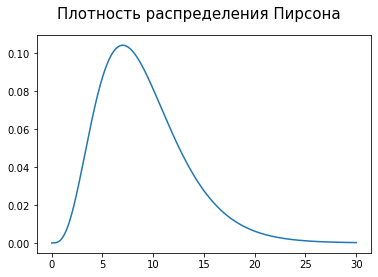

In [6]:
def P_density(x):
    return pow(x, (m-1)/2-1)*pow(math.e, -x/2)/(pow(2, (m-1)/2)*scipy.special.gamma((m-1)/2))

x_pir, y_pir = [], []
for i in range(1, 3000):
    x_pir.append(i/100) 
    y_pir.append(P_density(x_pir[-1]))
    
fig, ax = plt.subplots()
fig.suptitle('Плотность распределения Пирсона', size=15)
plt.plot(x_pir, y_pir)
plt.show()

In [7]:
probability = 1/m
delta_pir = sum([(sample[i]-n*probability)**2/(n*probability) for i in range(m)])
print('delta:', delta_pir)

res, err = scipy.integrate.quad(P_density, delta_pir, 30)
print('p-value:', res)

if res > alpha:
    print('Не можем отвергнуть гипотезу')
else:
    print('Отвергаем гипотезу')

delta: 16.4
p-value: 0.05854530877344011
Не можем отвергнуть гипотезу


# --------Пункт B--------

# Пирсон MMP

In [8]:
def Probability(a, b, teta1, teta2):
    def func(x):
        return pow(math.e, -pow((x-teta1)/teta2, 2)/2) / (teta2*math.sqrt(2*math.pi))
    res, err = scipy.integrate.quad(func, a, b)
    return res


def culc_L(teta1, teta2, sample):
    L = sample[0]*math.log(Probability(-math.inf, 0.5, teta1, teta2))
    for i in range(1, m-1):
        L += sample[i]*math.log(Probability(i-0.5, i+0.5, teta1, teta2))
    L += sample[m-1]*math.log(Probability(m-1-0.5, math.inf, teta1, teta2))
    return [L, teta1, teta2]


def MMP(sample):
    teta1 = 4
    teta2 = 2
    L_max = 0
    result = culc_L(teta1, teta2, sample)
    d = 0.02
    gal = 1
    while True:
        tmp_res = culc_L(result[1]+d*gal, result[2]+d*gal, sample)
        if tmp_res[0] > result[0]:
            result = tmp_res
            gal *= 2
            continue
        gal = 1
        tmp_res = culc_L(result[1]+d, result[2], sample)
        if tmp_res[0] > result[0]:
            result = tmp_res
            continue
        tmp_res = culc_L(result[1], result[2]+d, sample)
        if tmp_res[0] > result[0]:
            result = tmp_res
            continue
        break

    return result


L, teta1, teta2 = MMP(sample)

def ps(teta1, teta2):
    res = [Probability(-math.inf, 0.5, teta1, teta2)]
    res += [Probability(i-0.5, i+0.5, teta1, teta2) for i in range(1, m-1)]
    res.append(Probability(m-1-0.5, math.inf, teta1, teta2))
    return sum(res)

print(f'Проверка(сумма всех вероятностей должна быть 1): при teta1={teta1} и teta2={teta2} получил {ps(teta1, teta2)}')
    


Проверка(сумма всех вероятностей должна быть 1): при teta1=4.779999999999998 и teta2=2.7 получил 1.0000000000000002


In [9]:
tmp = n*Probability(-math.inf, 0.5, teta1, teta2)
delta_pir = (sample[0] - tmp)**2/tmp
for i in range(1, m-1):
    tmp = n*Probability(i-0.5, i+0.5, teta1, teta2)
    delta_pir += (sample[i] - tmp)**2/tmp
tmp = n*Probability(m-1-0.5, math.inf, teta1, teta2)
delta_pir += (sample[m-1] - tmp)**2/tmp
    
print('delta:', delta_pir)

def P_dens(x):
    return pow(x, (m-1-2)/2-1)*pow(math.e, -x/2)/(pow(2, (m-1-2)/2)*scipy.special.gamma((m-1-2)/2))


res, err = scipy.integrate.quad(P_dens, delta_pir, math.inf)
print('p-value:', res)
if res > alpha:
    print('Не можем отвергнуть гипотезу')
else:
    print('Отвергаем гипотезу')



delta: 9.816502691851735
p-value: 0.1992127774249331
Не можем отвергнуть гипотезу


# Колмогоров

In [52]:
from scipy import stats
import timeit

def N_density(x):
    return pow(math.e, -0.5*((x-teta1)/teta2)**2)/(teta2*math.sqrt(2*math.pi))

def format_sample(sample_bad):
    sample = [0]*10
    for el in sample_bad:
        if el < 0.5:
            sample[0] += 1
        elif el > m-1-0.5:
            sample[m-1] += 1
        else:    
            for i in range(1, m-1):
                if i-0.5 < el < i+0.5:
                    sample[i] += 1
    return sample
        
    

x_norm = [i for i in range(m)]
y_norm = [scipy.integrate.quad(N_density, -math.inf, 0)[0]]
for i in range(1, m):
    y_norm.append(y_norm[-1] + scipy.integrate.quad(N_density, i-1, i)[0])
    
delta_kalm = math.sqrt(n)*max([abs(F[i]-y_norm[i]) for i in range(m)]+[abs(F[i-1]-y_norm[i]) for i in range(1,m)])
print('delta:', delta_kalm)

N = 10000

deltas = []

for i in range(N):
    tmp_sample = format_sample(scipy.stats.norm.rvs(loc=teta1, scale=teta2, size=100))
    L, t1, t2 = MMP(tmp_sample)


    def func(x):
        return pow(math.e, -0.5*((x-t1)/t2)**2)/(t2*math.sqrt(2*math.pi))  
    tmp_y_norm = [scipy.integrate.quad(func, -math.inf, 0)[0]]

    for i in range(1, m):
        tmp_y_norm.append(tmp_y_norm[-1] + scipy.integrate.quad(func, i-1, i)[0])
    a = max([abs(F[i]-tmp_y_norm[i]) for i in range(m)])
    b = max([abs(F[i-1]-tmp_y_norm[i]) for i in range(1,m)])
    deltas.append(math.sqrt(n)*max(a, b))

deltas.sort()

for i in range(N-1):
    if deltas[i+1] >= delta_kalm > deltas[i]:
        print('p-value:', 1-(i-1)/N)
        if res > alpha:
            print('Не можем отвергнуть гипотезу')
        else:
            print('Отвергаем гипотезу')
        break


        
    

delta: 0.9752952577046281
p-value: 0.8588
Не можем отвергнуть гипотезу


# --------Пункт С--------

# Пирсон OMM

In [10]:
#print("Total time : %.3f ms" % (1000*timeit.timeit('MMP(sample)', globals=globals(), number=1)))
import timeit
def Ak_ass(k, sample):
    res = 0
    for i in range(len(sample)):
        res += sample[i]*i**k
    return res/n
        
def OMM(sample):
    t1 = Ak_ass(1, sample)
    t2 = math.sqrt(Ak_ass(2, sample) - t1**2)
    return [t1, t2]

teta1, teta2 = OMM(sample) 
#print("Total time : %.3f ms" % (1000*timeit.timeit('OMM(sample)', globals=globals(), number=1)))
print('teta1:',teta1, '\nteta2:', teta2)


teta1: 4.77 
teta2: 2.5054141374231933


In [16]:
def get_delta_pir(sample, teta1, teta2):
    tmp = n*Probability(-math.inf, 0.5, teta1, teta2)
    delta_pir = (sample[0] - tmp)**2/tmp
    for i in range(1, m-1):
        tmp = n*Probability(i-0.5, i+0.5, teta1, teta2)
        delta_pir += (sample[i] - tmp)**2/tmp
    tmp = n*Probability(m-1-0.5, math.inf, teta1, teta2)
    delta_pir += (sample[m-1] - tmp)**2/tmp
    return delta_pir
    
delta_pir = get_delta_pir(sample, teta1, teta2)
print(delta_pir)

10.798973140500916


# Bootstrap

[1.8332975563719711, 1.881483360934093, 1.956278519867939, 2.8892548412850325, 2.9255759351583803, 3.399363871454534, 3.4095531809737984, 3.4165964567375493, 3.4808441856115833, 3.6324497633575477, 3.6434878843005327, 3.8480554743562743, 3.9046696821896756, 3.9640650226293226, 4.0011407351142205, 4.155299730781921, 4.156677599046443, 4.205640672364956, 4.270157641501915, 4.301606754220824, 4.418175344501188, 4.60307320014648, 4.621521704092869, 4.624536441505593, 4.717126522656725, 4.753088885626332, 4.915767390397157, 4.918994413838514, 5.129542155731458, 5.363203316271559, 5.392009452700771, 5.544896094357174, 5.583281851661666, 5.586224402481548, 5.722551797949254, 5.7582466805527925, 5.873187862089605, 5.972512814740482, 6.035499195880347, 6.074846483150082, 6.160709086800806, 6.293487670038932, 6.365153060675466, 6.515278913273159, 6.538550634815474, 6.63537616348491, 6.764871748979145, 6.795233304213191, 6.799114068153754, 6.845953153738201, 6.871727709626218, 6.878860268638248, 

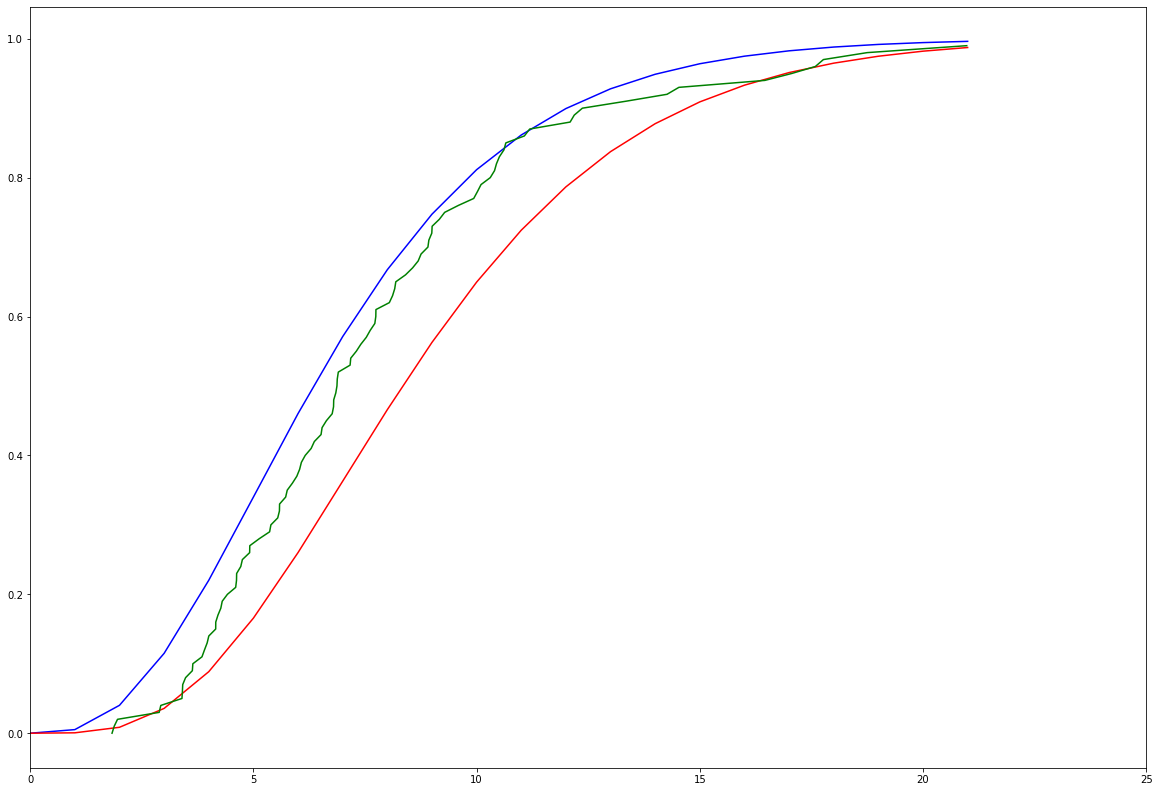

Зелёный - Бутстраповское распределение
Синий - Хи^2(7)
Красный - Хи^2(9)
10


In [15]:
from scipy import stats
import random

def format_sample(sample_bad):
    sample = [0]*m
    for el in sample_bad:
        if el < 0.5:
            sample[0] += 1
        elif el >= m-1 + 0.5:
            sample[m-1] += 1
        else:
            for i in range(1, m):
                if i-0.5 <= el < i+0.5:
                    sample[i] += 1
    return sample
        

def P_dens7(x):
    return pow(x, (7)/2-1)*pow(math.e, -x/2)/(pow(2, (7)/2)*scipy.special.gamma((7)/2))

def P_dens9(x):
    return pow(x, (9)/2-1)*pow(math.e, -x/2)/(pow(2, (9)/2)*scipy.special.gamma((9)/2))
N = 100


deltas = []

for i in range(N):
    tmp_sample = format_sample(scipy.stats.norm.rvs(loc=teta1, scale=teta2, size=100))
    #tmp_sample = [ra]
    t1, t2 = OMM(tmp_sample)
    deltas.append(get_delta_pir(tmp_sample, t1, t2))

deltas.sort()
print(deltas)
y_bt = [i/N for i in range(N)]


x = [i for i in range(round(deltas[-1]+1))]
y7 = [scipy.integrate.quad(P_dens7, 0, i)[0] for i in range(round(deltas[-1]+1))]
y9 = [scipy.integrate.quad(P_dens9, 0, i)[0] for i in range(round(deltas[-1]+1))]
plt.plot(x, y7, color='blue')
plt.plot(x, y9, color='red')
plt.plot(deltas, y_bt, color='green')
plt.xlim([0, 25])
plt.rcParams["figure.figsize"] = (20,14)
plt.show()
print('Зелёный - Бутстраповское распределение')
print('Синий - Хи^2(7)')
print('Красный - Хи^2(9)')
print(m)

In [ ]:
print(deltas)